In [24]:
import torch
import torch.nn as nn
import numpy as np
from scipy.integrate import odeint

In [16]:
# 生产者:水稻, 芒果, 稗草,初级消费者: 鼠, 椋鸟,蝗虫, 次级消费者:蛇, 蜘蛛, 顶级:狮子,  鹰类, 分解者:细菌,
species={
    "水稻":{
        "type":"producer",
        "source":"external",
        "id":0
    },
    "稗草":{
        "type":"producer",
        "source":"local",
        "id":1
    },
    "鼠":{
        "type":"primary_consumer",
        "source":"local",
        "id":2
    },
    "蝗虫":{
        "type":"primary_consumer",
        "source":"local",
        "id":3
    },
    "蛇":{
        "type":"secondary_consumer",
        "source":"local",
        "id":4
    },
    "蜘蛛":{
        "type":"secondary_consumer",
        "source":"local",
        "id":5
    },
    "鹰类":{
        "type":"top_consumer",
        "source":"local",
        "id":6
    },
    "细菌":{
        "type":"decomposer",
        "source":"local",
        "id":7
    }
}

In [40]:
relation=np.zeros((8,8))
for idx,name in enumerate(species.keys()):
    if species[name]["type"]=="producer":
        for a_idx,a_name in enumerate(species.keys()):
            if name==a_name:
                relation[idx][idx]=-1
            elif "primary_consumer" in species[a_name]["type"]:
                relation[a_idx][idx]=1
    elif species[name]["type"]=="decomposer":
        for a_idx,a_name in enumerate(species.keys()):
            if name==a_name:
                relation[idx][idx]=-1
            else:
                relation[idx][a_idx]=2
    relation[idx][idx]=-1
get_id=lambda x:species[x]["id"]
relation[get_id("蛇")][get_id("鼠")]=1
relation[get_id("蜘蛛")][get_id("蝗虫")]=1
relation[get_id("蛇")][get_id("蝗虫")]=1
relation[get_id("鹰类")][get_id("蛇")]=1
relation[get_id("鹰类")][get_id("蜘蛛")]=1
relation[get_id("鹰类")][get_id("鼠")]=1
# -1:自身, 1: A捕食B, 2:A分解B, 0:没有联系,
print(relation)

[[-1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.]
 [ 1.  1. -1.  0.  0.  0.  0.  0.]
 [ 1.  1.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  1.  1. -1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0. -1.  0.  0.]
 [ 0.  0.  1.  0.  1.  1. -1.  0.]
 [ 2.  2.  2.  2.  2.  2.  2. -1.]]


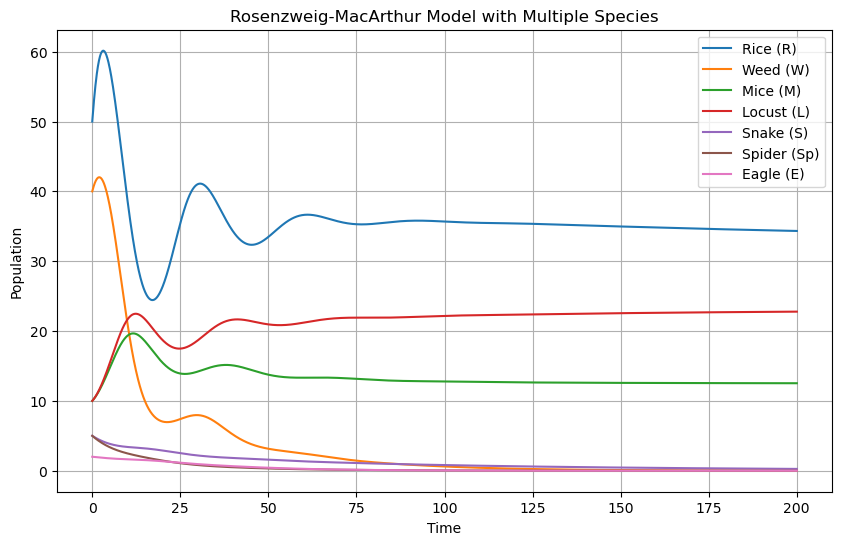

In [1]:
"""
鹰(顶级捕食者, 吃蛇和蜘蛛和鼠)
蛇(次级捕食者, 吃鼠和蝗虫)
蜘蛛(次级捕食者, 吃蝗虫)
鼠(初级捕食者, 吃水稻和稗草)
蝗虫(初级捕食者, 吃水稻和稗草)
水稻(生产者)
稗草(生产者)
细菌(分解者)
对细菌的预测, 用各其他生物的死亡率乘以响应生物的种群数量求和再乘以一个系数表示微生物的自然资源, 微生物也作为自然资源作用到两种消费者身上
建立相应的Rosenzweig-MacArthur 模型, 用scipy求解

"""
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def rosenzweig_macarthur_model(y, t, params):
    """
    Defines the ODEs for a 7-species Rosenzweig-MacArthur system:
      R(t)  : Rice
      W(t)  : Weed
      M(t)  : Mice
      L(t)  : Locust
      S(t)  : Snake
      Sp(t) : Spider
      E(t)  : Eagle
    """
    # Unpack state variables
    R, W, M, L, S, Sp, E = y

    # Unpack parameters (logistic growth, consumption, assimilation, death rates, etc.)
    (rR, KR, rW, KW,
     aRM, bRM, eMR, aRW, bRW, eMW,  # Mice consumption of Rice/Weed
     aLM, bLM, eML, aLW, bLW, eMW2, # Locust consumption of Rice/Weed
     aSM, bSM, eSM, aSL, bSL, eSL,  # Snake consumption of Mice/Locust
     aSpL, bSpL, eSpL,             # Spider consumption of Locust
     aES, bES, eES, aEM, bEM, eEM, aESp, bESp, eESp,
     dM, dL, dS, dSp, dE) = params

    # ----------------------------
    # Producers (Rice: R, Weed: W)
    # Logistic growth - sum of being eaten by Mice (M) and Locust (L)
    # Functional response: (aXY * X * Y) / (1 + bXY * X)
    # ----------------------------
    # dR/dt
    consumption_by_mice_R = (aRM * R * M) / (1 + bRM * R)
    consumption_by_locust_R = (aLM * R * L) / (1 + bLM * R)
    dRdt = rR * R * (1 - R / KR) - consumption_by_mice_R - consumption_by_locust_R

    # dW/dt
    consumption_by_mice_W = (aRW * W * M) / (1 + bRW * W)
    consumption_by_locust_W = (aLW * W * L) / (1 + bLW * W)
    dWdt = rW * W * (1 - W / KW) - consumption_by_mice_W - consumption_by_locust_W

    # ----------------------------
    # Primary consumers (Mice: M, Locust: L)
    # Gain from eating producers - loss from being eaten by predators
    # ----------------------------
    # dM/dt
    eaten_from_rice = eMR * consumption_by_mice_R
    eaten_from_weed = eMW * consumption_by_mice_W
    # Mice eaten by Snake and Eagle
    consumption_by_snake_on_mice = (aSM * M * S) / (1 + bSM * M)
    consumption_by_eagle_on_mice = (aEM * M * E) / (1 + bEM * M)
    dMdt = eaten_from_rice + eaten_from_weed \
           - consumption_by_snake_on_mice \
           - consumption_by_eagle_on_mice \
           - dM * M

    # dL/dt
    eaten_from_rice_L = eML * consumption_by_locust_R
    eaten_from_weed_L = eMW2 * consumption_by_locust_W
    # Locust eaten by Snake and Spider
    consumption_by_snake_on_locust = (aSL * L * S) / (1 + bSL * L)
    consumption_by_spider_on_locust = (aSpL * L * Sp) / (1 + bSpL * L)
    dLdt = eaten_from_rice_L + eaten_from_weed_L \
           - consumption_by_snake_on_locust \
           - consumption_by_spider_on_locust \
           - dL * L

    # ----------------------------
    # Secondary predators (Snake: S, Spider: Sp)
    # Gain from eating Mice/Locust - loss from being eaten by Eagle (Snake, Spider)
    # ----------------------------
    # dS/dt
    gain_snake_mice = eSM * consumption_by_snake_on_mice
    gain_snake_locust = eSL * consumption_by_snake_on_locust
    # Snake eaten by Eagle
    consumption_by_eagle_on_snake = (aES * S * E) / (1 + bES * S)
    dSdt = gain_snake_mice + gain_snake_locust \
           - consumption_by_eagle_on_snake \
           - dS * S

    # dSp/dt
    gain_spider_locust = eSpL * consumption_by_spider_on_locust
    # Spider eaten by Eagle
    consumption_by_eagle_on_spider = (aESp * Sp * E) / (1 + bESp * Sp)
    dSpdt = gain_spider_locust \
            - consumption_by_eagle_on_spider \
            - dSp * Sp

    # ----------------------------
    # Top predator (Eagle: E)
    # Gains from eating Snake, Mice, Spider - standard mortality
    # ----------------------------
    consumption_of_snake_by_eagle = (aES * S * E) / (1 + bES * S)
    consumption_of_mice_by_eagle = (aEM * M * E) / (1 + bEM * M)
    consumption_of_spider_by_eagle = (aESp * Sp * E) / (1 + bESp * Sp)
    gain_eagle_snake = eES * consumption_of_snake_by_eagle
    gain_eagle_mice = eEM * consumption_of_mice_by_eagle
    gain_eagle_spider = eESp * consumption_of_spider_by_eagle
    dEdt = gain_eagle_snake + gain_eagle_mice + gain_eagle_spider - dE * E

    return [dRdt, dWdt, dMdt, dLdt, dSdt, dSpdt, dEdt]


# Example parameter set (illustrative only)
params_example = (
    0.8, 100.0,  # rR, KR (Rice growth rate, carrying capacity)
    0.6, 80.0,   # rW, KW (Weed growth rate, carrying capacity)

    0.02, 0.01, 0.2,  # aRM, bRM, eMR (Mice consuming Rice)
    0.015, 0.01, 0.2, # aRW, bRW, eMW (Mice consuming Weed)

    0.02, 0.01, 0.2,  # aLM, bLM, eML (Locust consuming Rice)
    0.02, 0.01, 0.2,  # aLW, bLW, eMW2 (Locust consuming Weed)

    0.01, 0.01, 0.3,  # aSM, bSM, eSM (Snake consuming Mice)
    0.01, 0.01, 0.3,  # aSL, bSL, eSL (Snake consuming Locust)

    0.01, 0.01, 0.35, # aSpL, bSpL, eSpL (Spider consuming Locust)

    0.01, 0.01, 0.4,  # aES, bES, eES (Eagle consumes Snake)
    0.01, 0.01, 0.4,  # aEM, bEM, eEM (Eagle consumes Mice)
    0.01, 0.01, 0.4,  # aESp, bESp, eESp (Eagle consumes Spider)

    0.1, 0.1, 0.1, 0.1, 0.1  # dM, dL, dS, dSp, dE (natural death rates)
)

# Initial populations: R, W, M, L, S, Sp, E
y0 = [50, 40, 10, 10, 5, 5, 2]

# Time points
t = np.linspace(0, 200, 2001)

# Solve ODE
solution = odeint(rosenzweig_macarthur_model, y0, t, args=(params_example,))

# Extract each population from the solution
R_sol, W_sol, M_sol, L_sol, S_sol, Sp_sol, E_sol = solution.T

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(t, R_sol, label='Rice (R)')
plt.plot(t, W_sol, label='Weed (W)')
plt.plot(t, M_sol, label='Mice (M)')
plt.plot(t, L_sol, label='Locust (L)')
plt.plot(t, S_sol, label='Snake (S)')
plt.plot(t, Sp_sol, label='Spider (Sp)')
plt.plot(t, E_sol, label='Eagle (E)')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Rosenzweig-MacArthur Model with Multiple Species')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
"""
鹰(顶级捕食者, 吃蛇和蜘蛛和鼠)
蛇(次级捕食者, 吃鼠和蝗虫)
蜘蛛(次级捕食者, 吃蝗虫)
鼠(初级捕食者, 吃水稻和稗草)
蝗虫(初级捕食者, 吃水稻和稗草)
水稻(生产者)
稗草(生产者)
建立相应的Rosenzweig-MacArthur 模型, 用scipy求解, 带细菌的版本
"""
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
def rosenzweig_macarthur_model(y, t, params):
    """
    Defines the ODEs for a 7-species Rosenzweig-MacArthur system:
      R(t)  : Rice
      W(t)  : Weed
      M(t)  : Mice
      L(t)  : Locust
      S(t)  : Snake
      Sp(t) : Spider
      E(t)  : Eagle
    """
    # Unpack state variables
    R, W, M, L, S, Sp, E,B = y

    # Unpack parameters (logistic growth, consumption, assimilation, death rates, etc.)
    (rR, KR, rW, KW,
     aRM, bRM, eMR, aRW, bRW, eMW,  # Mice consumption of Rice/Weed
     aLM, bLM, eML, aLW, bLW, eMW2, # Locust consumption of Rice/Weed
     aSM, bSM, eSM, aSL, bSL, eSL,  # Snake consumption of Mice/Locust
     aSpL, bSpL, eSpL,             # Spider consumption of Locust
     aES, bES, eES, aEM, bEM, eEM, aESp, bESp, eESp,
     dM, dL, dS, dSp, dE, dB,rB, kB,sP1,sP2) = params
    # dB:微生物分解系数
    # ----------------------------
    # Producers (Rice: R, Weed: W)
    # Logistic growth - sum of being eaten by Mice (M) and Locust (L)
    # Functional response: (aXY * X * Y) / (1 + bXY * X)
    # ----------------------------
    # dR/dt
    consumption_by_mice_R = (aRM * R * M) / (1 + bRM * R)
    consumption_by_locust_R = (aLM * R * L) / (1 + bLM * R)
    dRdt = rR * R * (1 - R / KR) - consumption_by_mice_R - consumption_by_locust_R

    # dW/dt
    consumption_by_mice_W = (aRW * W * M) / (1 + bRW * W)
    consumption_by_locust_W = (aLW * W * L) / (1 + bLW * W)
    dWdt = rW * W * (1 - W / KW) - consumption_by_mice_W - consumption_by_locust_W

    # ----------------------------
    # Primary consumers (Mice: M, Locust: L)
    # Gain from eating producers - loss from being eaten by predators
    # ----------------------------
    # dM/dt
    eaten_from_rice = eMR * consumption_by_mice_R
    eaten_from_weed = eMW * consumption_by_mice_W
    # Mice eaten by Snake and Eagle
    consumption_by_snake_on_mice = (aSM * M * S) / (1 + bSM * M)
    consumption_by_eagle_on_mice = (aEM * M * E) / (1 + bEM * M)
    dMdt = eaten_from_rice + eaten_from_weed \
           - consumption_by_snake_on_mice \
           - consumption_by_eagle_on_mice \
           - dM * M

    # dL/dt
    eaten_from_rice_L = eML * consumption_by_locust_R
    eaten_from_weed_L = eMW2 * consumption_by_locust_W
    # Locust eaten by Snake and Spider
    consumption_by_snake_on_locust = (aSL * L * S) / (1 + bSL * L)
    consumption_by_spider_on_locust = (aSpL * L * Sp) / (1 + bSpL * L)
    dLdt = eaten_from_rice_L + eaten_from_weed_L \
           - consumption_by_snake_on_locust \
           - consumption_by_spider_on_locust \
           - dL * L

    # ----------------------------
    # Secondary predators (Snake: S, Spider: Sp)
    # Gain from eating Mice/Locust - loss from being eaten by Eagle (Snake, Spider)
    # ----------------------------
    # dS/dt
    gain_snake_mice = eSM * consumption_by_snake_on_mice
    gain_snake_locust = eSL * consumption_by_snake_on_locust
    # Snake eaten by Eagle
    consumption_by_eagle_on_snake = (aES * S * E) / (1 + bES * S)
    dSdt = gain_snake_mice + gain_snake_locust \
           - consumption_by_eagle_on_snake \
           - dS * S

    # dSp/dt
    gain_spider_locust = eSpL * consumption_by_spider_on_locust
    # Spider eaten by Eagle
    consumption_by_eagle_on_spider = (aESp * Sp * E) / (1 + bESp * Sp)
    dSpdt = gain_spider_locust \
            - consumption_by_eagle_on_spider \
            - dSp * Sp


    # ----------------------------
    # Top predator (Eagle: E)
    # Gains from eating Snake, Mice, Spider - standard mortality
    # ----------------------------
    consumption_of_snake_by_eagle = (aES * S * E) / (1 + bES * S)
    consumption_of_mice_by_eagle = (aEM * M * E) / (1 + bEM * M)
    consumption_of_spider_by_eagle = (aESp * Sp * E) / (1 + bESp * Sp)
    gain_eagle_snake = eES * consumption_of_snake_by_eagle
    gain_eagle_mice = eEM * consumption_of_mice_by_eagle
    gain_eagle_spider = eESp * consumption_of_spider_by_eagle
    dEdt = gain_eagle_snake + gain_eagle_mice + gain_eagle_spider - dE * E
    # dB/dt

    tot_death=abs(R*dRdt)+abs(W*dWdt)+abs(M*dMdt)+abs(L*dLdt)+abs(S*dSdt)+abs(Sp*dSpdt)+abs(E*dEdt)
    B_input=dB*tot_death
    dBdt=B_input-(kB*B)/()
    return [dRdt, dWdt, dMdt, dLdt, dSdt, dSpdt, dEdt]


# Example parameter set (illustrative only)
params_example = (
    0.8, 100.0,  # rR, KR (Rice growth rate, carrying capacity)
    0.6, 80.0,   # rW, KW (Weed growth rate, carrying capacity)

    0.02, 0.01, 0.2,  # aRM, bRM, eMR (Mice consuming Rice)
    0.015, 0.01, 0.2, # aRW, bRW, eMW (Mice consuming Weed)

    0.02, 0.01, 0.2,  # aLM, bLM, eML (Locust consuming Rice)
    0.02, 0.01, 0.2,  # aLW, bLW, eMW2 (Locust consuming Weed)

    0.01, 0.01, 0.3,  # aSM, bSM, eSM (Snake consuming Mice)
    0.01, 0.01, 0.3,  # aSL, bSL, eSL (Snake consuming Locust)

    0.01, 0.01, 0.35, # aSpL, bSpL, eSpL (Spider consuming Locust)

    0.01, 0.01, 0.4,  # aES, bES, eES (Eagle consumes Snake)
    0.01, 0.01, 0.4,  # aEM, bEM, eEM (Eagle consumes Mice)
    0.01, 0.01, 0.4,  # aESp, bESp, eESp (Eagle consumes Spider)

    0.1, 0.1, 0.1, 0.1, 0.1  # dM, dL, dS, dSp, dE (natural death rates),
    , 0.1, 0.01,200.0, 0.0001,0.0001 # dB, rB, kB, sP1,sP2微生物分解系数,微生物自然资源消耗率, 自然承载率,两种植物的吸收率
)

# Initial populations: R, W, M, L, S, Sp, E
y0 = [50, 40, 10, 10, 5, 5, 2, 100000]

# Time points
t = np.linspace(0, 200, 2001)

# Solve ODE
solution = odeint(rosenzweig_macarthur_model, y0, t, args=(params_example,))

# Extract each population from the solution
R_sol, W_sol, M_sol, L_sol, S_sol, Sp_sol, E_sol = solution.T

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(t, R_sol, label='Rice (R)')
plt.plot(t, W_sol, label='Weed (W)')
plt.plot(t, M_sol, label='Mice (M)')
plt.plot(t, L_sol, label='Locust (L)')
plt.plot(t, S_sol, label='Snake (S)')
plt.plot(t, Sp_sol, label='Spider (Sp)')
plt.plot(t, E_sol, label='Eagle (E)')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Rosenzweig-MacArthur Model with Multiple Species')
plt.legend()
plt.grid(True)
plt.show()
"""
微生物需要的资源
化学元素, 用各其他生物死亡率乘以其死亡率相加再乘以一个分解系数衡量

"""